In [1]:
import pandas as pd
import numpy as np
import cassiopeia as cas
import seaborn as sns
from os.path import join, exists
from os import makedirs, getcwd
from pandarallel import pandarallel
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import pickle

In [2]:
# af_f = "/data2/mito_lineage/data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/post/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/af_by_cell.tsv"
# dp_f = "/data2/mito_lineage/data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/post/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/af_by_cell.DP.tsv"
# ad_f = "/data2/mito_lineage/data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/post/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/af_by_cell.AD.tsv"
donors = "/data2/mito_lineage/data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex/cells_meta.tsv"
prefix= "TcellDupi_may17_2021/MTblacklist"
name = "post_cass_test"
indir = "./output/data/"
outdir = "./output/data/treecluster_out/"

In [3]:
indir = join(indir, prefix)
outdir = join(outdir, prefix)
if not exists(outdir):
    print(f"Making outdir {outdir} in folder {getcwd()}")
    makedirs(outdir)

out_clusters = join(outdir, f"{name}_clusters")

In [4]:
in_tree = join(indir, f'{name}_hybrid.tree')

## Build dendrogram of the clusters by taking the medoids. 

## Load donors

In [5]:
donors_df = pd.read_csv(donors, sep='\t').astype({"donor":"Int32", "donor_index":"Int32"})
donors_df


,index,ID,raw ID,new index,condition,donor,donor_index
0,0,AAACGAAAGCCGCAAA-1_pre,AAACGAAAGCCGCAAA-1,1,pre,0,1
1,1,AAACGAAAGGCTCCTG-1_pre,AAACGAAAGGCTCCTG-1,2,pre,1,1
2,2,AAACGAAAGTAGCAAT-1_pre,AAACGAAAGTAGCAAT-1,3,pre,0,2
3,3,AAACGAAAGTGAATAC-1_pre,AAACGAAAGTGAATAC-1,4,pre,1,2
4,4,AAACGAAAGTGTCACT-1_pre,AAACGAAAGTGTCACT-1,5,pre,1,3
...,...,...,...,...,...,...,...
15584,15584,TTTGTGTTCCGGAAAG-1_post,TTTGTGTTCCGGAAAG-1,15585,post,0,8015
15585,15585,TTTGTGTTCCTGACCT-1_post,TTTGTGTTCCTGACCT-1,15586,post,0,8016
15586,15586,TTTGTGTTCGGATGTT-1_post,TTTGTGTTCGGATGTT-1,15587,post,1,6745
15587,15587,TTTGTGTTCTTAATCC-1_post,TTTGTGTTCTTAATCC-1,15588,post,0,8017


## Loop through multiple distance thresholds and run

In [5]:
for ind in range(10,40):
    cmd = f"TreeCluster.py -t {ind} -i {in_tree} > {out_clusters}.t{ind}.tsv"
    print(cmd)
    !{cmd}

TreeCluster.py -t 10 -i ./output/data/TcellDupi_may17_2021/MTblacklist/post_cass_test_hybrid.tree > ./output/data/treecluster_out/TcellDupi_may17_2021/MTblacklist/post_cass_test_clusters.t10.tsv
TreeCluster.py -t 11 -i ./output/data/TcellDupi_may17_2021/MTblacklist/post_cass_test_hybrid.tree > ./output/data/treecluster_out/TcellDupi_may17_2021/MTblacklist/post_cass_test_clusters.t11.tsv
TreeCluster.py -t 12 -i ./output/data/TcellDupi_may17_2021/MTblacklist/post_cass_test_hybrid.tree > ./output/data/treecluster_out/TcellDupi_may17_2021/MTblacklist/post_cass_test_clusters.t12.tsv
TreeCluster.py -t 13 -i ./output/data/TcellDupi_may17_2021/MTblacklist/post_cass_test_hybrid.tree > ./output/data/treecluster_out/TcellDupi_may17_2021/MTblacklist/post_cass_test_clusters.t13.tsv
TreeCluster.py -t 14 -i ./output/data/TcellDupi_may17_2021/MTblacklist/post_cass_test_hybrid.tree > ./output/data/treecluster_out/TcellDupi_may17_2021/MTblacklist/post_cass_test_clusters.t14.tsv
TreeCluster.py -t 15 -i .

In [6]:
treeresults = {}
for ind in range(10,40):
    treeresults[ind] = pd.read_csv(f"{out_clusters}.t{ind}.tsv", sep='\t').groupby("ClusterNumber").size()


In [7]:
treeresults_all = pd.concat(treeresults).reset_index().rename({"level_0": "t", 0:"num_cells"}, axis=1)
treeresults_all

,t,ClusterNumber,num_cells
0,10,-1,7
1,10,1,51
2,10,2,12
3,10,3,2
4,10,4,6
...,...,...,...
3145,39,27,292
3146,39,28,208
3147,39,29,162
3148,39,30,85


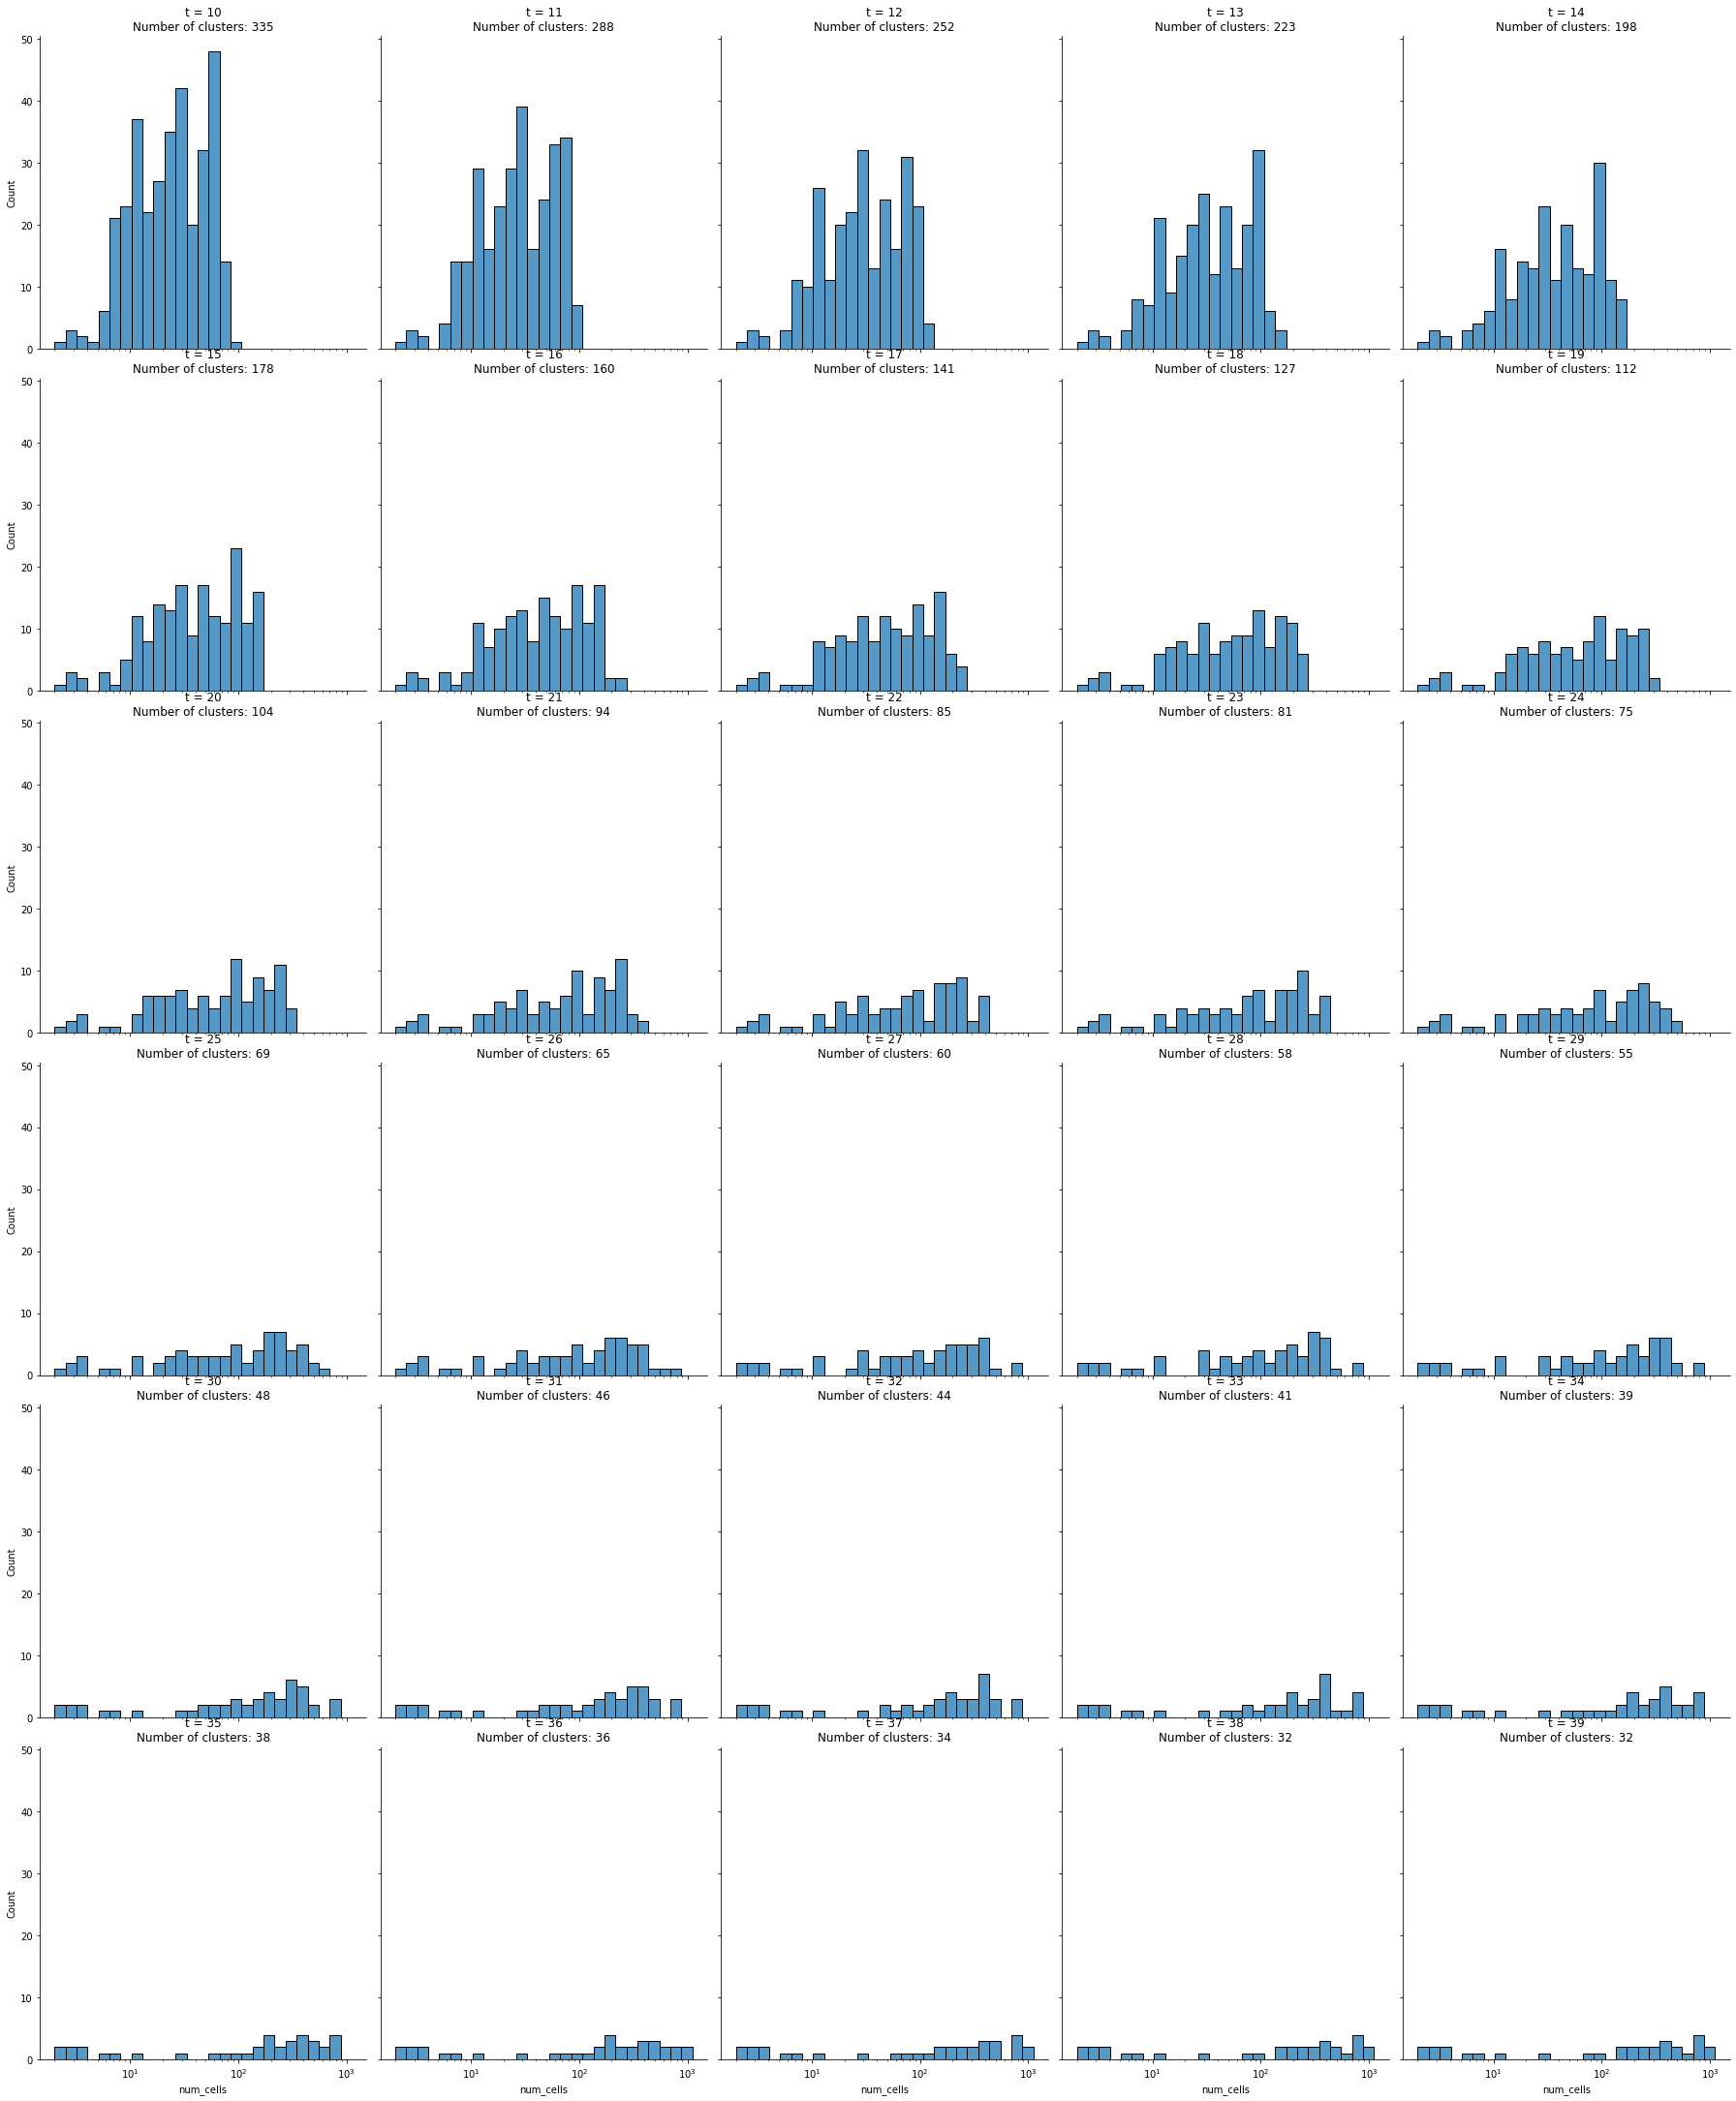

In [73]:
#g = sns.FacetGrid(data=treeresults_all, col='t', col_wrap=5)
g = sns.displot(data=treeresults_all, x="num_cells", col='t', col_wrap=5, log_scale=True)
for ax in g.axes.flatten():
    #print(ax.get_title())
    curr_txt = str(ax.get_title())
    curr_group = curr_txt.split(" = ")[-1]
    ax.set_title(f'{str(ax.get_title())}\nNumber of clusters: {treeresults_all[treeresults_all["t"] == int(curr_group)].shape[0]}')

## Calculate silhouette

## Compare clusters to donors

In [8]:
t39 = pd.read_csv(f"{out_clusters}.t39.tsv", sep='\t')
t39_clust = treeresults_all[treeresults_all["t"] ==39]
t39

,SequenceName,ClusterNumber
0,CCTGCTAAGGATTAAC-1,-1
1,GTTGGTAAGGCGCTTC-1,1
2,GGAGTAGCAAGGAGGG-1,1
3,CAACCAAGTGCGACCT-1,1
4,TGGTCCTAGACTAATG-1,1
...,...,...
10046,AGGCGTCGTCCTTCAC-1,31
10047,GATTAGCGTTGGAGGT-1,31
10048,AACAAAGGTTTGACCA-1,31
10049,ACCGCAGAGAGAGTAG-1,31


## Filter for 'post' condition

In [9]:
post_donors_df = donors_df[donors_df["condition"]=="post"]
post_donors_df

,index,ID,raw ID,new index,condition,donor,donor_index
5538,5538,AAACGAAAGAACAGGA-1_post,AAACGAAAGAACAGGA-1,5539,post,0,2721
5539,5539,AAACGAAAGATTGACA-1_post,AAACGAAAGATTGACA-1,5540,post,0,2722
5540,5540,AAACGAAAGCGTTGCC-1_post,AAACGAAAGCGTTGCC-1,5541,post,1,2614
5541,5541,AAACGAAAGGTACTCT-1_post,AAACGAAAGGTACTCT-1,5542,post,0,2723
5542,5542,AAACGAAAGGTTAACA-1_post,AAACGAAAGGTTAACA-1,5543,post,1,2615
...,...,...,...,...,...,...,...
15584,15584,TTTGTGTTCCGGAAAG-1_post,TTTGTGTTCCGGAAAG-1,15585,post,0,8015
15585,15585,TTTGTGTTCCTGACCT-1_post,TTTGTGTTCCTGACCT-1,15586,post,0,8016
15586,15586,TTTGTGTTCGGATGTT-1_post,TTTGTGTTCGGATGTT-1,15587,post,1,6745
15587,15587,TTTGTGTTCTTAATCC-1_post,TTTGTGTTCTTAATCC-1,15588,post,0,8017


## Merge by cell IDs

In [22]:
donors_clusters = pd.merge(t39, post_donors_df, left_on="SequenceName", right_on="raw ID")
donors_clusters

,SequenceName,ClusterNumber,index,ID,raw ID,new index,condition,donor,donor_index
0,CCTGCTAAGGATTAAC-1,-1,8942,CCTGCTAAGGATTAAC-1_post,CCTGCTAAGGATTAAC-1,8943,post,1,4001
1,GTTGGTAAGGCGCTTC-1,1,12603,GTTGGTAAGGCGCTTC-1_post,GTTGGTAAGGCGCTTC-1,12604,post,1,5477
2,GGAGTAGCAAGGAGGG-1,1,11622,GGAGTAGCAAGGAGGG-1_post,GGAGTAGCAAGGAGGG-1,11623,post,1,5071
3,CAACCAAGTGCGACCT-1,1,7876,CAACCAAGTGCGACCT-1_post,CAACCAAGTGCGACCT-1,7877,post,1,3554
4,TGGTCCTAGACTAATG-1,1,14602,TGGTCCTAGACTAATG-1_post,TGGTCCTAGACTAATG-1,14603,post,1,6331
...,...,...,...,...,...,...,...,...,...
10046,AGGCGTCGTCCTTCAC-1,31,7263,AGGCGTCGTCCTTCAC-1_post,AGGCGTCGTCCTTCAC-1,7264,post,0,3668
10047,GATTAGCGTTGGAGGT-1,31,10640,GATTAGCGTTGGAGGT-1_post,GATTAGCGTTGGAGGT-1,10641,post,0,5423
10048,AACAAAGGTTTGACCA-1,31,5741,AACAAAGGTTTGACCA-1_post,AACAAAGGTTTGACCA-1,5742,post,0,2827
10049,ACCGCAGAGAGAGTAG-1,31,6486,ACCGCAGAGAGAGTAG-1_post,ACCGCAGAGAGAGTAG-1,6487,post,0,3232


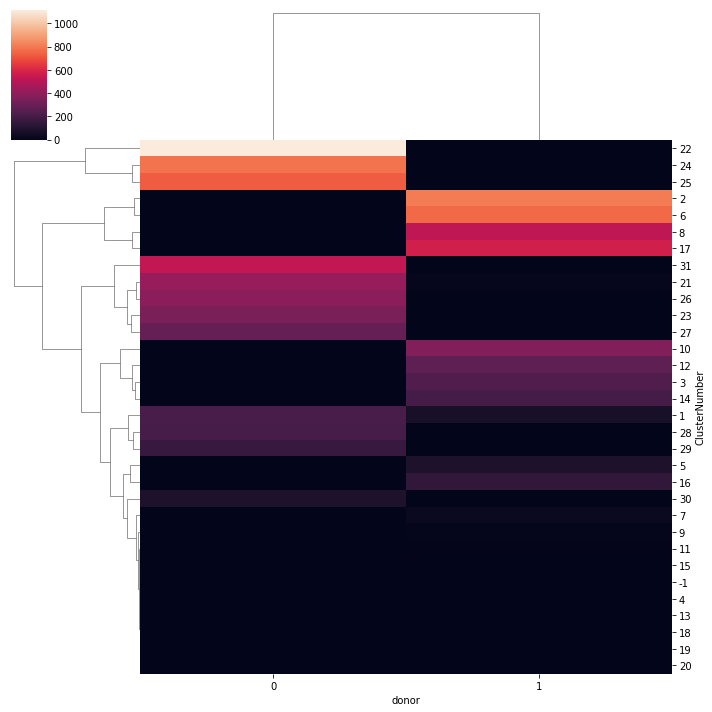

In [28]:
%matplotlib inline
sns.clustermap(donors_clusters.groupby(["ClusterNumber", "donor"]).size().reset_index().pivot(index="ClusterNumber",
                                                                                             columns="donor", 
                                                                                             values=0).fillna(0))

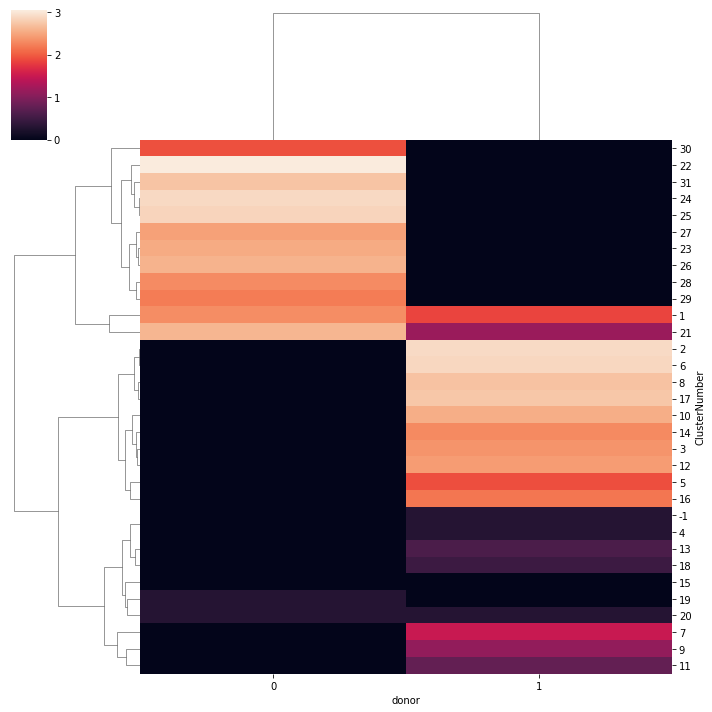

In [29]:
%matplotlib inline
sns.clustermap(np.log10(donors_clusters.groupby(["ClusterNumber", "donor"]).size().reset_index().pivot(index="ClusterNumber",
                                                                                             columns="donor", 
                                                                                             values=0).fillna(1)))

## Result: The donors do in fact separate out by cluster!